In [48]:
import os
import numpy as np
import cv2
from tqdm import tqdm
import skimage.io as io
import matplotlib.pyplot as plt

from datasets.coco.create_annotation_coco import *

ann_file = "D:/Datasets/COCO/annotations/instances_train2017.json"
from pycocotools import coco
mycoco = coco.COCO(ann_file)

loading annotations into memory...
Done (t=35.16s)
creating index...
index created!


### Show all annotations including a crowd and crowd only annotations

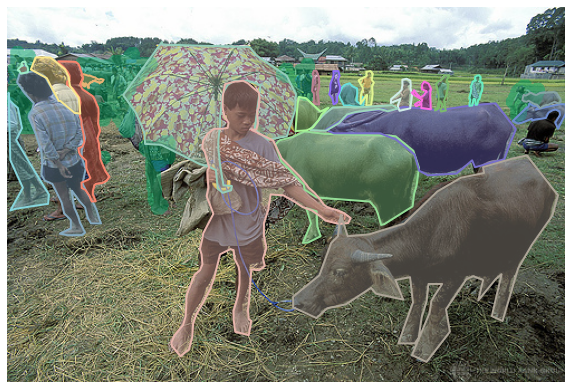

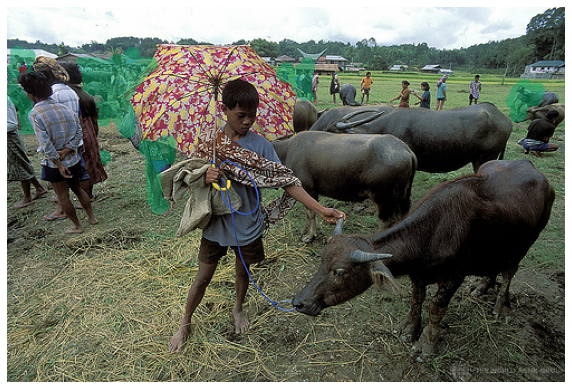

Crowd annotations
[{'area': 8340, 'iscrowd': 1, 'image_id': 184613, 'bbox': [0, 35, 481, 150], 'category_id': 1, 'id': 900100184613}]


In [49]:
def show_crowd():
    # Select an image
    for img_id in mycoco.imgs:
        out = False
        ann_ids = mycoco.getAnnIds(imgIds=[img_id])
        anns = mycoco.loadAnns(ann_ids)
        anns_crowd = [a for a in anns if a['iscrowd']]
        if len(anns_crowd) != 0:
            break

    img = mycoco.loadImgs(ids=[img_id])[0]
    I = io.imread(img['coco_url'])
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(I)
    mycoco.showAnns(anns)
    plt.show()

    img = mycoco.loadImgs(ids=[img_id])[0]
    I = io.imread(img['coco_url'])
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(I)
    mycoco.showAnns(anns_crowd)
    plt.show()

    print('Crowd annotations')
    for i in range(len(anns_crowd)):
        anns_crowd[i].pop('segmentation')
    print(anns_crowd)

show_crowd()

### Create a map of all categories

In [50]:
coco_cat_id2pos = np.zeros(100, dtype=np.int32) - 1
coco_cat_pos2id = np.zeros(80, dtype=np.int32)

for i, cat_id in enumerate(sorted(mycoco.cats)):
    coco_cat_id2pos[cat_id] = i
    coco_cat_pos2id[i] = cat_id

voc_classes = {
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair',
     'cow', 'dining table', 'dog', 'horse', 'motorbike', 'person', 'potted plant',
     'sheep', 'sofa', 'train', 'tvmonitor'
}

extra = {
    'aeroplane': 'airplane',
    'sofa': 'couch',
    'tvmonitor': 'tv',
    'motorbike': 'motorcycle'
}

voc_classes_in_coco = voc_classes.copy()
for key, value in extra.items():
    voc_classes_in_coco.remove(key)
    voc_classes_in_coco.add(value)

coco_cat_name_to_cat_id = dict()
for cat_id in mycoco.cats:
    name = mycoco.cats[cat_id]['name']
    coco_cat_name_to_cat_id[name] = cat_id

voc_classes_in_coco_cat_ids = np.array(sorted(
    [coco_cat_name_to_cat_id[name] for name in voc_classes_in_coco]))
voc_classes_in_coco_pos_ids = np.array(sorted(
    [coco_cat_id2pos[cat_id] for cat_id in voc_classes_in_coco_cat_ids]))
print('VOC')
print(voc_classes_in_coco_cat_ids)
print(voc_classes_in_coco_pos_ids)
coco_classes_only_cat_ids = np.array(sorted(list(
    set(mycoco.cats) - set(voc_classes_in_coco_cat_ids))))
coco_classes_only_pos_ids = np.array(sorted(
    [coco_cat_id2pos[id] for id in coco_classes_only_cat_ids]))
print('COCO')
print(len(coco_classes_only_cat_ids), coco_classes_only_cat_ids)
print(len(coco_classes_only_pos_ids), coco_classes_only_pos_ids)

VOC
[ 1  2  3  4  5  6  7  9 16 17 18 19 20 21 44 62 63 64 67 72]
[ 0  1  2  3  4  5  6  8 14 15 16 17 18 19 39 56 57 58 60 62]
COCO
60 [ 8 10 11 13 14 15 22 23 24 25 27 28 31 32 33 34 35 36 37 38 39 40 41 42
 43 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 65 70 73 74 75 76 77
 78 79 80 81 82 84 85 86 87 88 89 90]
60 [ 7  9 10 11 12 13 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37
 38 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 59 61 63 64 65 66 67
 68 69 70 71 72 73 74 75 76 77 78 79]


### Filter images and develop an algorithm


In [51]:
filtered_dict, ann_lower_imgs_ids_subset, ann_lower_anns_ids_subset  = filter_coco(mycoco, show_stats=True, return_ann_lower=True)

100%|██████████| 118287/118287 [00:11<00:00, 10680.62it/s]


Example
Image info {'license': 3, 'file_name': '000000184613.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000184613.jpg', 'height': 336, 'width': 500, 'date_captured': '2013-11-14 12:36:29', 'flickr_url': 'http://farm3.staticflickr.com/2169/2118578392_1193aa04a0_z.jpg', 'id': 184613}
Image new width and height 1190 800
Annotation: {'area': 143.45519999999945, 'iscrowd': 0, 'image_id': 184613, 'bbox': [272.72, 56.58, 6.37, 30.54], 'category_id': 1, 'id': 1686503}
Annotation new width and height: 15 72
Total images in the new list 108109
-> crowd_anns   10052 imgs with them 9115
-> ignored_anns 0 imgs with them 0
-> zero_inter   2 imgs with them 2
-> bad_ann      0 imgs with them 0
-> ann_lower    71523 imgs with them 22595
Distribution of objects smaller than 16 in h/w on a final image
[('person', 22648), ('book', 6187), ('car', 4773), ('traffic light', 3994), ('bottle', 3180), ('bird', 2306), ('kite', 2024), ('sports ball', 1872), ('boat', 1650), ('chair', 1554), ('kni

Choosing one annotation from  71523
Image ID 390756
->Ann ID 405014
Ann {'area': 94.94825000000009, 'iscrowd': 0, 'image_id': 390756, 'bbox': [260.02, 23.8, 5.8, 17.1], 'category_id': 10, 'id': 405014}
Category traffic light
->Ann ID 409908
Ann {'area': 95.00399999999995, 'iscrowd': 0, 'image_id': 390756, 'bbox': [4.32, 83.15, 6.68, 16.4], 'category_id': 10, 'id': 409908}
Category traffic light
->Ann ID 411177
Ann {'area': 99.0019499999998, 'iscrowd': 0, 'image_id': 390756, 'bbox': [367.62, 75.37, 6.09, 20.76], 'category_id': 10, 'id': 411177}
Category traffic light
->Ann ID 1307292
Ann {'area': 118.02155000000033, 'iscrowd': 0, 'image_id': 390756, 'bbox': [317.38, 128.28, 6.49, 28.76], 'category_id': 1, 'id': 1307292}
Category person
->Ann ID 1691817
Ann {'area': 120.93804999999998, 'iscrowd': 0, 'image_id': 390756, 'bbox': [78.28, 121.16, 7.76, 19.94], 'category_id': 1, 'id': 1691817}
Category person
->Ann ID 1739474
Ann {'area': 24.802299999999942, 'iscrowd': 0, 'image_id': 390756, 

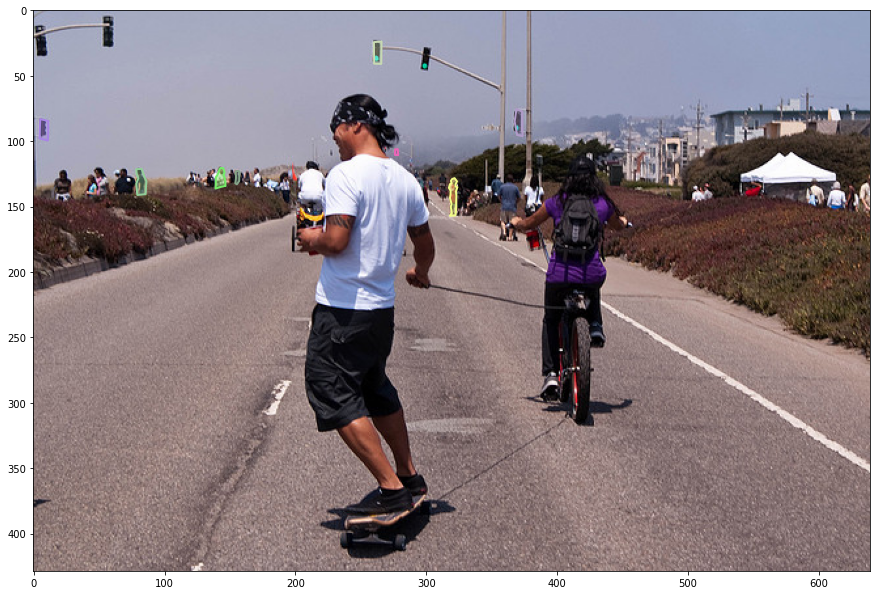

In [52]:

def show_lowers(coco_subset, imgs_ids_subset, anns_ids_subset):
    print('Choosing one annotation from ', len(anns_ids_subset))
    i = np.random.choice(len(anns_ids_subset))
    cur_img_id = imgs_ids_subset[i]
    cur_ann_ids = anns_ids_subset[imgs_ids_subset == cur_img_id]
    cur_anns = mycoco.loadAnns(ids=cur_ann_ids)

    print('Image ID', cur_img_id)
    for cur_ann in cur_anns:
        print('->Ann ID', cur_ann['id'])
        print('Ann', {tk : tv for tk, tv in cur_ann.items() if tk != 'segmentation'})
        cur_cat =  coco_subset.cats[cur_ann['category_id']]['name']
        print('Category', cur_cat)

    img = coco_subset.imgs[cur_img_id]
    print('Image info', img)
    I = io.imread(img['coco_url'])
    plt.figure(figsize=(15, 15))
    plt.imshow(I)
    coco_subset.showAnns(cur_anns)
    plt.show()

show_lowers(mycoco, ann_lower_imgs_ids_subset, ann_lower_anns_ids_subset)

### Create an array for all images

In [53]:
presense_arr = np.zeros((len(filtered_dict), 80), dtype=np.uint8)
for i, img_id in enumerate(filtered_dict):
    ann_ids = filtered_dict[i]['ann_ids']
    anns = mycoco.loadAnns(ids=ann_ids)
    for el in anns:
        coco_cat_id = el['category_id']
        pos = coco_cat_id2pos[coco_cat_id]
        presense_arr[i, pos] += 1

### Collect one part of a finetuning dataset with *C-Base*
### 1. Select a subset from COCO train which does not have VOC cats at all (finetuning)

In [54]:
voc_classes_in = np.array(presense_arr[:, voc_classes_in_coco_pos_ids]).sum(axis=-1)
imgs_no_voc_classes = np.where(voc_classes_in == 0)[0]
print('Images with no VOC classes', len(imgs_no_voc_classes))

Images with no VOC classes 21591


### 2. Sort selected images by the amount of objects on an image (in a descending order)

In [55]:
total_objects_amount = presense_arr[imgs_no_voc_classes, :].sum(axis=-1)
indices = np.argsort(total_objects_amount)[::-1]
imgs_no_voc_classes_desc = imgs_no_voc_classes[indices]
print(presense_arr[imgs_no_voc_classes_desc].sum(axis=-1))

[30 29 28 ...  1  1  1]


### 3. Remove images with no objects annotated and with more than 3K objects of the same class

In [56]:
k = 1
indices = np.nonzero(
    (presense_arr[imgs_no_voc_classes_desc].sum(axis=-1)) * \
    (presense_arr[imgs_no_voc_classes_desc].max(axis=-1) <= 3 * k)
)
imgs_no_voc_classes_desc_non_zero = imgs_no_voc_classes_desc[indices]
imgs_pool = presense_arr[imgs_no_voc_classes_desc_non_zero]
print(imgs_pool.sum(axis=-1))

[14 13 13 ...  1  1  1]


### 4. Check that images in a selection do not have VOC class examples (and crowd examples also)

In [57]:
# Images with crowds are removed on the start
selection = imgs_pool[:, voc_classes_in_coco_pos_ids]
print('Array with images, only VOC labels', selection.shape)
print(selection.min(), selection.max())
del selection

Array with images, only VOC labels (18318, 20)
0 0


### 5. Check that images in a selection have all COCO classes with at least K examples for each category (and no crowd examples)

In [58]:
# Images with crowds are removed on the start
print('COCO indices of categories presented in COCO only')
print(coco_classes_only_cat_ids)
print('Position indices of the same categories')
print(coco_classes_only_pos_ids)

selection = imgs_pool[:, coco_classes_only_pos_ids]
coco_classes_only_presence_vec = selection.sum(axis=0)
print('Representation')
print(coco_classes_only_presence_vec)
k = 1
indices_no_3k = np.where(coco_classes_only_presence_vec < 3 * k)[0]
print('Critical categories')
print(indices_no_3k)
print(coco_classes_only_pos_ids[indices_no_3k])
# Less or more all categories are represented in the

COCO indices of categories presented in COCO only
[ 8 10 11 13 14 15 22 23 24 25 27 28 31 32 33 34 35 36 37 38 39 40 41 42
 43 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 65 70 73 74 75 76 77
 78 79 80 81 82 84 85 86 87 88 89 90]
Position indices of the same categories
[ 7  9 10 11 12 13 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37
 38 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 59 61 63 64 65 66 67
 68 69 70 71 72 73 74 75 76 77 78 79]
Representation
[ 588  903  561  665  159  768 1570 1083 2351 2783  130  147  185   82
  396   36   26   19   80  156   17   23   36   52   22   99 1093  385
  459  381 1037  611  418  559  496  688  439  269  817  213  525  886
 2328  377  263  196  366  396  404  746   32 1943  473  620 2219  822
  309  782   53  245]
Critical categories
[]
[]


### 6. For each category, check amount of images with one instance, two instances, ...

In [59]:
for pos_id in coco_classes_only_pos_ids:
    column = imgs_pool[:, pos_id]
    appearings = {}
    for i in range(1, max(column) + 1):
        appearings[i] = np.count_nonzero(column == i)
    print(pos_id, appearings)
# Seems that there are a lot images with one and two instances

7 {1: 354, 2: 75, 3: 28}
9 {1: 269, 2: 179, 3: 92}
10 {1: 541, 2: 7, 3: 2}
11 {1: 622, 2: 14, 3: 5}
12 {1: 68, 2: 41, 3: 3}
13 {1: 495, 2: 84, 3: 35}
20 {1: 423, 2: 332, 3: 161}
21 {1: 607, 2: 178, 3: 40}
22 {1: 486, 2: 559, 3: 249}
23 {1: 826, 2: 611, 3: 245}
24 {1: 86, 2: 13, 3: 6}
25 {1: 105, 2: 15, 3: 4}
26 {1: 138, 2: 19, 3: 3}
27 {1: 53, 2: 7, 3: 5}
28 {1: 168, 2: 63, 3: 34}
29 {1: 25, 2: 4, 3: 1}
30 {1: 16, 2: 2, 3: 2}
31 {1: 13, 2: 3}
32 {1: 57, 2: 7, 3: 3}
33 {1: 69, 2: 18, 3: 17}
34 {1: 14, 2: 0, 3: 1}
35 {1: 16, 2: 2, 3: 1}
36 {1: 30, 2: 3}
37 {1: 34, 2: 6, 3: 2}
38 {1: 17, 2: 1, 3: 1}
40 {1: 57, 2: 18, 3: 2}
41 {1: 565, 2: 183, 3: 54}
42 {1: 331, 2: 24, 3: 2}
43 {1: 332, 2: 44, 3: 13}
44 {1: 250, 2: 43, 3: 15}
45 {1: 612, 2: 136, 3: 51}
46 {1: 332, 2: 87, 3: 35}
47 {1: 154, 2: 63, 3: 46}
48 {1: 281, 2: 112, 3: 18}
49 {1: 202, 2: 78, 3: 46}
50 {1: 251, 2: 109, 3: 73}
51 {1: 114, 2: 68, 3: 63}
52 {1: 132, 2: 49, 3: 13}
53 {1: 510, 2: 95, 3: 39}
54 {1: 72, 2: 36, 3: 23}
55 {1:

### 7. For each category, count images where this category is the only one represented
(to understand how difficult it may be to fold the selection)

In [60]:
cat_num_on_img = (imgs_pool > 0).sum(axis=-1)
print('Distribution on amount of different categories on images \n'
      'which do not contain VOC classes, crowds, have at least \n'
      '1 object from only-COCO-not-VOC-category annotated')
unique, counts = np.unique(cat_num_on_img, return_counts=True)
print(np.array(list(zip(unique, counts))))

Distribution on amount of different categories on images 
which do not contain VOC classes, crowds, have at least 
1 object from only-COCO-not-VOC-category annotated
[[    1 13057]
 [    2  3506]
 [    3  1157]
 [    4   390]
 [    5   130]
 [    6    51]
 [    7    19]
 [    8     5]
 [    9     1]
 [   10     1]
 [   12     1]]


In [61]:
indices_only_1cat = np.where((imgs_pool > 0).sum(axis=-1) == 1)[0]
print('Amount of images with only 1 category', len(indices_only_1cat))
selection = imgs_pool[indices_only_1cat]
print('Selection shape', selection.shape)

for pos_id in coco_classes_only_pos_ids:
    column = selection[:, pos_id]
    unique, counts = np.unique(column, return_counts=True)
    print('Cat', pos_id, dict(zip(unique, counts)))
del selection

Amount of images with only 1 category 13057
Selection shape (13057, 80)
Cat 7 {0: 12716, 1: 257, 2: 58, 3: 26}
Cat 9 {0: 12614, 1: 217, 2: 151, 3: 75}
Cat 10 {0: 12575, 1: 474, 2: 6, 3: 2}
Cat 11 {0: 12510, 1: 530, 2: 12, 3: 5}
Cat 12 {0: 12964, 1: 55, 2: 36, 3: 2}
Cat 13 {0: 12589, 1: 375, 2: 67, 3: 26}
Cat 20 {0: 12200, 1: 377, 2: 323, 3: 157}
Cat 21 {0: 12287, 1: 557, 2: 173, 3: 40}
Cat 22 {0: 11908, 1: 420, 2: 505, 3: 224}
Cat 23 {0: 11524, 1: 745, 2: 571, 3: 217}
Cat 24 {0: 13054, 1: 2, 3: 1}
Cat 25 {0: 12987, 1: 57, 2: 11, 3: 2}
Cat 26 {0: 13053, 1: 3, 2: 1}
Cat 27 {0: 13033, 1: 19, 2: 2, 3: 3}
Cat 28 {0: 12917, 1: 89, 2: 32, 3: 19}
Cat 29 {0: 13036, 1: 17, 2: 3, 3: 1}
Cat 30 {0: 13042, 1: 12, 2: 1, 3: 2}
Cat 31 {0: 13048, 1: 9}
Cat 32 {0: 13051, 1: 4, 2: 2}
Cat 33 {0: 12958, 1: 65, 2: 17, 3: 17}
Cat 34 {0: 13051, 1: 6}
Cat 35 {0: 13055, 2: 2}
Cat 36 {0: 13029, 1: 26, 2: 2}
Cat 37 {0: 13028, 1: 24, 2: 4, 3: 1}
Cat 38 {0: 13051, 1: 4, 2: 1, 3: 1}
Cat 40 {0: 13048, 1: 6, 2: 2, 3: 1

### 8. Sort by the amount of representation


In [62]:
imgs_set_hidden_indexes = set()
total_cat_examples_in_set = np.zeros(80)
total_cat_examples_in_set[voc_classes_in_coco_pos_ids] = -1
order = np.argsort(coco_classes_only_presence_vec)
coco_classes_ascending_pos_ids = coco_classes_only_pos_ids[order]
total_required = 3 * k

for n, pos_id in enumerate(coco_classes_ascending_pos_ids):
    # Select images which have this category
    selection = imgs_pool[:, pos_id]
    hidden_indices = np.where(selection != 0)[0]
    mid_indices = imgs_no_voc_classes_desc_non_zero[hidden_indices]
    real_indices = [filtered_dict[index]['img_id'] for index in mid_indices]
    represented = imgs_pool[hidden_indices]
    print(f'Cat '
          f'pos_id {pos_id}; ',
          f'cat_id {coco_cat_pos2id[pos_id]}; ',
          f'name {mycoco.cats[coco_cat_pos2id[pos_id]]["name"]}; ',
          'total images with this cat', len(represented))

    selected_num_this_cat_examples = represented[:, pos_id]
    selected_num_each_cat_examples = (represented > 0).sum(axis=-1)
    selected_triple = np.array(list(zip(selected_num_this_cat_examples,
                                        selected_num_each_cat_examples,
                                        hidden_indices)))
    groups = {amount: [] for amount in np.unique(selected_num_this_cat_examples)}
    for amount in groups:
        amount_group_indices = np.where(selected_triple[:, 0] == amount)[0]
        amount_group = selected_triple[amount_group_indices, :]
        if len(amount_group) > 1:
            order = np.argsort(amount_group[:, 1])
            amount_group = amount_group[order]
        groups[amount] = amount_group

    # Check that all images with these indices have this category (even show images)
    check_required = False
    for real_index in real_indices:
        ann_ids = mycoco.getAnnIds(imgIds=[real_index])
        anns = mycoco.loadAnns(ann_ids)
        cat_ids = [el['category_id'] for el in anns]
        this_cat_id = coco_cat_pos2id[pos_id]
        assert this_cat_id in cat_ids
        if not check_required:
            print('Checked ONE image and everything is OK')
            break
    if check_required:
        print('Checked ALL images and everything is OK')

    # Perform a selection
    triples_selected = []
    for amount in sorted(groups):
        if total_cat_examples_in_set[pos_id] == total_required:
            # print('Out of a main loop with success')
            break
        # print('Trying amount', amount)
        while total_cat_examples_in_set[pos_id] + amount > total_required:
            if len(triples_selected) == 0:
                raise NotImplementedError
            # Two strategies: random and try to delete less
            # triple_index = np.random.choice(len(triples_selected), replace=False)
            triple_index = 0
            triple = triples_selected[triple_index]
            hidden_img_index = triple[2]
            imgs_set_hidden_indexes.remove(hidden_img_index)
            total_cat_examples_in_set -= imgs_pool[hidden_img_index]
            del triples_selected[triple_index]
            print('Deleted triple', triple)

        for triple in groups[amount]:
            _, _, hidden_img_index = triple
            cur_img_cats = imgs_pool[hidden_img_index]
            assert cur_img_cats[pos_id] == amount
            summary = total_cat_examples_in_set + cur_img_cats
            if max(summary) > total_required:
                # print('More than required', summary)
                continue
            else:
                total_cat_examples_in_set = summary
                imgs_set_hidden_indexes.add(hidden_img_index)
                triples_selected.append(triple)
                # print('Added ', triple)
                if total_cat_examples_in_set[pos_id] == total_required:
                    success = True
                    # print('Chosen successfully')
                    break

        # print('Finished with amount', amount)
        # print(np.array(triples_selected))
    print('Finished for this cat')

print('*** Finished for all cats *** ')


Cat pos_id 34;  cat_id 39;  name baseball bat;  total images with this cat 15
Checked ONE image and everything is OK
Finished for this cat
Cat pos_id 31;  cat_id 36;  name snowboard;  total images with this cat 16
Checked ONE image and everything is OK
Finished for this cat
Cat pos_id 38;  cat_id 43;  name tennis racket;  total images with this cat 19
Checked ONE image and everything is OK
Finished for this cat
Cat pos_id 35;  cat_id 40;  name baseball glove;  total images with this cat 19
Checked ONE image and everything is OK
Finished for this cat
Cat pos_id 30;  cat_id 35;  name skis;  total images with this cat 20
Checked ONE image and everything is OK
Finished for this cat
Cat pos_id 70;  cat_id 80;  name toaster;  total images with this cat 31
Checked ONE image and everything is OK
Finished for this cat
Cat pos_id 36;  cat_id 41;  name skateboard;  total images with this cat 33
Checked ONE image and everything is OK
Finished for this cat
Cat pos_id 29;  cat_id 34;  name frisbee; 

In [63]:
print('Total images in the set', len(imgs_set_hidden_indexes))
print('Amount of class instances depicted\n', total_cat_examples_in_set)
imgs_list_hidden_indexes = list(imgs_set_hidden_indexes)
mid_indices = imgs_no_voc_classes_desc_non_zero[imgs_list_hidden_indexes]
real_indices = [filtered_dict[index]['img_id'] for index in mid_indices]
print(imgs_pool[imgs_list_hidden_indexes].sum(axis=0))
print(presense_arr[mid_indices].sum(axis=0))

Total images in the set 172
Amount of class instances depicted
 [-1. -1. -1. -1. -1. -1. -1.  3. -1.  3.  3.  3.  3.  3. -1. -1. -1. -1.
 -1. -1.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3. -1.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3. -1. -1. -1.  3. -1.  3. -1.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.]
[0 0 0 0 0 0 0 3 0 3 3 3 3 3 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 3 0 3 0 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3]
[0 0 0 0 0 0 0 3 0 3 3 3 3 3 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 3 0 3 0 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3]


In [64]:
ann_ids = mycoco.getAnnIds(imgIds=real_indices)
anns = mycoco.loadAnns(ann_ids)
s = set([el['category_id'] for el in anns])
print('Total amount of categories depicted', len(s))

Total amount of categories depicted 63


In [65]:
file_names = [mycoco.imgs[i]['file_name'] for i in real_indices]
print(file_names[:5])
from cp_utils.cp_dir_file_ops import write_json_safe, write_json_unsafe
write_json_safe(f'coco_few_shot_res/file_names_k{k}.json', file_names)

['000000072273.jpg', '000000393169.jpg', '000000283043.jpg', '000000030529.jpg', '000000529434.jpg']
JSON WRITE-SAFE OK coco_few_shot_res/file_names_k1.json


In [66]:
print(real_indices[:10])
write_json_safe(f'coco_few_shot_res/real_indices_k{k}.json', real_indices)

[72273, 393169, 283043, 30529, 529434, 491579, 363523, 4079, 391214, 136540]
JSON WRITE-SAFE OK coco_few_shot_res/real_indices_k1.json
